In [ ]:
# FLICKR8k IMAGE CAPTIONING WITH CNN-LSTM

This notebook provides utilities and a full pipeline for:
- Extracting image features using pretrained CNNs (VGG16, EfficientNetV2, InceptionV3, Xception).
- Processing Flickr8k captions.
- Building vocabulary, preparing paired data.
- Defining and training an image captioning model (CNN encoder + LSTM decoder).
- Evaluating using BLEU scores, and visualizing metrics.

**Author:** <Epoch Engineers (Darshan Tapdia, Ritika Verma, Navdeep Khandelwal, Kapil, Divya Jain, Adi )>
**Date:** 2025-09-17

**Requirements:** TensorFlow, numpy, nltk, matplotlib


In [1]:
import os
import json
from pickle import dump, load
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import nltk
from nltk.translate.bleu_score import corpus_bleu, SmoothingFunction
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dropout, Dense, Embedding, LSTM, add
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical, Sequence


In [2]:
MODEL_INFO = {
    "vgg16": {
        "cls": tf.keras.applications.VGG16,
        "preprocess": tf.keras.applications.vgg16.preprocess_input,
        "size": (224,224)
    },
    "efficientnetv2": {
        "cls": tf.keras.applications.EfficientNetV2B0,
        "preprocess": tf.keras.applications.efficientnet_v2.preprocess_input,
        "size": (224,224)
    },
    "inceptionv3": {
        "cls": tf.keras.applications.InceptionV3,
        "preprocess": tf.keras.applications.inception_v3.preprocess_input,
        "size": (224,224)
    },
    "xception": {
        "cls": tf.keras.applications.Xception,
        "preprocess": tf.keras.applications.xception.preprocess_input,
        "size": (299,299)
    }
}


In [3]:
from google.colab import drive
drive.mount('/content/drive')
BASE_DIR = '/content/drive/My Drive/Colab Notebooks/'

Mounted at /content/drive


In [ ]:
## Step 1: Image Loading/Preprocessing


In [26]:
def load_and_preprocess_images(directory, preprocess, target_size):
    """
    Load and preprocess all images from the given directory using the selected CNN requirements.
    Args:
        directory (str): Path to image directory.
        preprocess (function): Model-specific preprocess_input.
        target_size (tuple): Image resize shape.
    Returns:
        dict: {image_id: preprocessed_image_array}
    """
    images = dict()
    for name in os.listdir(directory):
        if not (name.lower().endswith('.jpg') or name.lower().endswith('.jpeg') or name.lower().endswith('.png')):
            continue
        filename = os.path.join(directory, name)
        image = tf.keras.utils.load_img(filename, target_size=target_size)
        image = tf.keras.utils.img_to_array(image)
        image = image.reshape((1, *image.shape))
        image = preprocess(image)
        image_id = name.split('.')[0]
        images[image_id] = image
        #print(f"[INFO] Loaded {name} (id={image_id})")
    print(f"[INFO] Finished: {len(images)} images loaded.")
    return images


In [ ]:
## Step 2: CNN Feature Extraction


In [27]:
def extract_features_from_images(images, model_cls, target_size):
    """
    Use a pretrained CNN to extract features (embeddings) from preprocessed images.
    Args:
        images (dict): {image_id: image_tensor}
        model_cls: Keras model class (from tf.keras.applications).
        target_size (tuple): Image shape.
    Returns:
        dict: {image_id: feature_vector}
    """
    input_layer = tf.keras.layers.Input(shape=(*target_size, 3))
    model = model_cls(include_top=False, input_tensor=input_layer, pooling='avg')
    print("[INFO] CNN Model Summary:")
    print(model.summary())
    features = dict()
    for image_id, image_array in images.items():
        feature = model.predict(image_array, verbose=0)
        features[image_id] = feature
        #print(f"[INFO] Extracted features for {image_id}")
    print(f"[INFO] Total feature vectors: {len(features)}")
    return features


In [ ]:
## Step 3: Caption File Utilities


In [28]:
import string

def load_and_clean_flickr8k_captions(token_file):
    """
    Load and clean captions from Flickr8k.token.txt.
    Returns: {img_id: [cleaned_caption1, cleaned_caption2, ...]}
    Each caption is:
     - lowercased
     - punctuation removed
     - only alphabetic words kept
     - prepended with 'startseq' and appended with 'endseq'
    """
    table = str.maketrans('', '', string.punctuation)
    caption_dict = {}
    with open(token_file, 'r', encoding='utf-8') as f:
        for line in f:
            line = line.strip()
            if not line:
                continue
            img_and_idx, *caption_words = line.split()
            img_id = img_and_idx.split('.')[0]
            # Clean caption:
            caption = " ".join(caption_words).lower()
            caption = caption.translate(table)
            caption = " ".join(word for word in caption.split() if word.isalpha())
            cleaned_caption = f"startseq {caption} endseq"
            caption_dict.setdefault(img_id, []).append(cleaned_caption)
    print(f"[INFO] Loaded and cleaned captions for {len(caption_dict)} images.")
    return caption_dict



In [ ]:
## Step 4: Data Preparation

Choose params below, modify paths for your environment.


In [ ]:
model_name = "xception"  # or 'efficientnetv2', 'inceptionv3', 'vgg'
image_dir = "/content/drive/My Drive/Colab Notebooks/Flicker8k_Dataset/"
output_pkl = "/content/drive/My Drive/Colab Notebooks/features.pkl"
model_info = MODEL_INFO[model_name]
target_size = model_info["size"]
preprocess = model_info["preprocess"]
model_cls = model_info["cls"]

print("\n[INFO] Loading and preprocessing images...")
images = load_and_preprocess_images(image_dir, preprocess, target_size)
print(f"[INFO] Total images loaded: {len(images)}")

print("\n[INFO] Extracting features from images...")
features = extract_features_from_images(images, model_cls, target_size)
print(f"[INFO] Total features extracted: {len(features)}")

print(f"\n[INFO] Saving features to '{output_pkl}' ...")
with open(output_pkl, 'wb') as fp:
    dump(features, fp)
print(f"[INFO] Features saved to '{output_pkl}'.")



[INFO] Loading and preprocessing images...


In [ ]:
## Step 5: Caption Conversion Example


In [29]:
token_file = "/content/drive/My Drive/Colab Notebooks/Flickr8k_text/Flickr8k.token.txt"
output_json = "/content/drive/My Drive/Colab Notebooks/captions.json"
print(f"\n[INFO] Processing captions from {token_file} ...")
img2captions = load_and_clean_flickr8k_captions(token_file)
print(f"[INFO] Unique images found: {len(img2captions)}")
with open(output_json, "w", encoding='utf-8') as f:
    json.dump(img2captions, f, ensure_ascii=False, indent=2)
print(f"[INFO] JSON written to {output_json}")



[INFO] Processing captions from /content/drive/My Drive/Colab Notebooks/Flickr8k_text/Flickr8k.token.txt ...
[INFO] Loaded and cleaned captions for 8092 images.
[INFO] Unique images found: 8092
[INFO] JSON written to /content/drive/My Drive/Colab Notebooks/captions.json


In [ ]:
## Step 6: Data Loading Helpers


In [30]:
def load_train_features(encoded_pkl):
    with open(encoded_pkl, "rb") as f:
        features = load(f)
    print(f"[INFO] Loaded {len(features)} train image features")
    return features

def load_captions(filename):
    with open(filename) as f:
        descriptions = json.load(f)
    print(f"[INFO] Loaded descriptions for {len(descriptions)} images")
    return descriptions

def build_vocab(descriptions, threshold=10):
    word_counts = {}
    for caps in descriptions.values():
        for cap in caps:
            for word in cap.split():
                word_counts[word] = word_counts.get(word, 0) + 1
    vocab = [w for w, c in word_counts.items() if c >= threshold]
    print(f"[INFO] Vocabulary size (threshold={threshold}): {len(vocab)}")
    word_to_idx = {w: i + 1 for i, w in enumerate(vocab)}
    idx_to_word = {i + 1: w for i, w in enumerate(vocab)}
    word_to_idx['startseq'] = len(word_to_idx) + 1
    word_to_idx['endseq'] = len(word_to_idx) + 1
    idx_to_word[len(idx_to_word) + 1] = 'startseq'
    idx_to_word[len(idx_to_word) + 1] = 'endseq'
    return vocab, word_to_idx, idx_to_word

def max_caption_length(descriptions):
    return max(len(cap.split()) for caps in descriptions.values() for cap in caps)



In [ ]:
## Step 7: Tokenizer and Sequence Processing

Build tokenizer, process captions to input-output sequences suitable for model training.


In [31]:
from tensorflow.keras.preprocessing.text import Tokenizer

def create_tokenizer(descriptions):
    lines = []
    for cap_list in descriptions.values():
        for cap in cap_list:
            lines.append('startseq ' + cap + ' endseq')
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    print(f"[INFO] Vocabulary Size: {len(tokenizer.word_index) + 1}")
    return tokenizer

def max_caption_length(descriptions):
    lines = []
    for cap_list in descriptions.values():
        lines.extend(['startseq ' + cap + ' endseq' for cap in cap_list])
    maxlen = max(len(d.split()) for d in lines)
    print(f"[INFO] Maximum Caption Length: {maxlen}")
    return maxlen


In [ ]:
## Step 8: Training Sequence Data Generator

A Keras generator for (image features, input sequence) → (next word).


In [32]:
class CaptioningSequence(Sequence):
    def __init__(self, descriptions, encoding_train, word_to_idx, max_len, batch_size, **kwargs):
        super().__init__(**kwargs)
        self.descs = descriptions
        self.features = encoding_train
        self.word_to_idx = word_to_idx
        self.max_len = max_len
        self.batch_size = batch_size
        #self.vocab_size = len(word_to_idx) + 1
        self.vocab_size = max(word_to_idx.values()) + 1
        self.img_cap_pairs = []
        self.missing_keys = []
        for key in descriptions.keys():
            if key not in encoding_train:
                self.missing_keys.append(key)
                continue
            for desc in descriptions[key]:
                self.img_cap_pairs.append((key, desc))
        if self.missing_keys:
            print(f"[WARNING] {len(self.missing_keys)} images in captions had no features. First missing: {self.missing_keys[:3]}")
    def __len__(self):
        return int(np.ceil(len(self.img_cap_pairs) / self.batch_size))
    def __getitem__(self, idx):
        X1, X2, y = [], [], []
        start = idx * self.batch_size
        end = min((idx+1) * self.batch_size, len(self.img_cap_pairs))
        pairs = self.img_cap_pairs[start:end]
        for key, desc in pairs:
            photo = self.features[key]
            if photo.ndim == 2 and photo.shape[0] == 1:
                photo = photo[0]
            seq = [self.word_to_idx[word] for word in desc.split() if word in self.word_to_idx]
            for i in range(1, len(seq)):
                in_seq, out_seq = seq[:i], seq[i]
                in_seq = pad_sequences([in_seq], maxlen=self.max_len, value=0, padding='post')[0]
                out_seq = to_categorical([out_seq], num_classes=self.vocab_size)[0]
                X1.append(photo)
                X2.append(in_seq)
                y.append(out_seq)
        if len(X1) == 0:
            feature_shape = next(iter(self.features.values()))
            if feature_shape.ndim == 2 and feature_shape.shape[0] == 1:
                feature_shape = feature_shape[0]
            return (np.empty((0, *feature_shape.shape)), np.empty((0, self.max_len))), np.empty((0, self.vocab_size))
        return (np.array(X1), np.array(X2)), np.array(y)


In [ ]:
## Step 9: Model Architecture (CNN-LSTM)


In [33]:
from tensorflow.keras.metrics import Precision, Recall, F1Score

def build_model(vocab_size, max_len, feature_dim=2048):
    input_img_features = Input(shape=(feature_dim,))
    inp_img1 = Dropout(0.30)(input_img_features)
    inp_img2 = Dense(256, activation='relu')(inp_img1)
    input_captions = Input(shape=(max_len,))
    inp_cap1 = Embedding(input_dim=vocab_size, output_dim=50, mask_zero=True)(input_captions)
    inp_cap2 = Dropout(0.30)(inp_cap1)
    inp_cap3 = LSTM(256)(inp_cap2)
    decoder1 = add([inp_img2, inp_cap3])
    decoder2 = Dense(256, activation='relu')(decoder1)
    outputs = Dense(vocab_size, activation='softmax')(decoder2)
    model = Model(inputs=[input_img_features, input_captions], outputs=outputs)
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy', Precision(), Recall(), F1Score()])
    print(model.summary())
    return model

In [ ]:
## Step 10: Prepare Data and Train Model

Load processed features/captions and start training.


In [34]:
import os
import json
import pickle
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split

# ---- Helper functions assumed available ----
# load_train_features, load_captions, build_vocab, max_caption_length, build_model, CaptioningSequence

features_path = "/content/drive/My Drive/Colab Notebooks/features.pkl"
captions_path = "/content/drive/My Drive/Colab Notebooks/captions.json"
WEIGHTS_PATH = "/content/drive/My Drive/Colab Notebooks/best.weights.h5"
VOCAB_DICT_PATH = "/content/drive/My Drive/Colab Notebooks/vocab_dicts.json"


# ---- Load all data ----
encoding_all = load_train_features(features_path)
descriptions_all = load_captions(captions_path)

# ---- Dynamic train/test split ----
all_keys = list(set(descriptions_all.keys()) & set(encoding_all.keys()))
train_ids, test_ids = train_test_split(all_keys, test_size=0.1, random_state=42)
print(f"[INFO] Split: {len(train_ids)} train and {len(test_ids)} test images.")

train_captions = {k: descriptions_all[k] for k in train_ids}
test_captions = {k: descriptions_all[k] for k in test_ids}
train_features = {k: encoding_all[k] for k in train_ids}
test_features = {k: encoding_all[k] for k in test_ids}

# ---- Build vocab & maxlen from train only! ----
vocab, word_to_idx, idx_to_word = build_vocab(train_captions, threshold=10)
#vocab_size = len(word_to_idx) + 1
vocab_size = max(word_to_idx.values()) + 1
max_len = max_caption_length(train_captions)
print(vocab_size)

# ---- Store mappings for later inference ----
vocab_info = {
    'word_to_idx': word_to_idx,
    'idx_to_word': {str(k): v for k, v in idx_to_word.items()}
}
with open(VOCAB_DICT_PATH, 'w') as f:
    json.dump(vocab_info, f)
print(f"[INFO] Max caption length: {max_len}")
print(f"[INFO] Saved vocab dicts.")

[INFO] Loaded 8091 train image features
[INFO] Loaded descriptions for 8092 images
[INFO] Split: 7281 train and 810 test images.
[INFO] Vocabulary size (threshold=10): 1848
[INFO] Maximum Caption Length: 39
1850
[INFO] Max caption length: 39
[INFO] Saved vocab dicts.


In [35]:

EPOCHS = 35
BATCH_SIZE = 32

# ---- Build model ----
model = build_model(vocab_size, max_len, feature_dim=2048)
print(model.summary())

# ---- Check or resume weights ----
if os.path.exists(WEIGHTS_PATH):
    print(f"[INFO] Found weights at '{WEIGHTS_PATH}'. Loading and skipping training ...")
    model.load_weights(WEIGHTS_PATH)
    # Can use model for inference or further training if needed
else:
    print("[INFO] No weights found. Starting NEW training ...")
    checkpoint = ModelCheckpoint(
        filepath=WEIGHTS_PATH,
        save_weights_only=True,
        save_best_only=True,
        monitor='loss',  # Could be 'val_loss' if using a validation set
        mode='min',
        verbose=1
    )
    # --- Data generator ---
    generator = CaptioningSequence(train_captions, train_features, word_to_idx, max_len, BATCH_SIZE)
    print(f"[INFO] Starting training for {EPOCHS} epochs ...")
    hist = model.fit(generator, epochs=EPOCHS, verbose=1, callbacks=[checkpoint])
    print("[INFO] Training complete.")


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_7       │ (None, 39)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_6       │ (None, 2048)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_3         │ (None, 39, 50)    │     92,500 │ input_layer_7[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_6 (Dropout) │ (None, 2048)      │          0 │ input_layer_6[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_7 (Dropout) │ (None, 39, 50)    │          0 │ embedding_3[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_3         │ (None, 39)        │          0 │ input_layer_7[0]… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_9 (Dense)     │ (None, 256)       │    524,544 │ dropout_6[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_3 (LSTM)       │ (None, 256)       │    314,368 │ dropout_7[0][0],  │
│                     │                   │            │ not_equal_3[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_3 (Add)         │ (None, 256)       │          0 │ dense_9[0][0],    │
│                     │                   │            │ lstm_3[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_10 (Dense)    │ (None, 256)       │     65,792 │ add_3[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_11 (Dense)    │ (None, 1850)      │    475,450 │ dense_10[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,472,654 (5.62 MB)

 Trainable params: 1,472,654 (5.62 MB)

 Non-trainable params: 0 (0.00 B)

None


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_7       │ (None, 39)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_6       │ (None, 2048)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_3         │ (None, 39, 50)    │     92,500 │ input_layer_7[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_6 (Dropout) │ (None, 2048)      │          0 │ input_layer_6[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_7 (Dropout) │ (None, 39, 50)    │          0 │ embedding_3[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_3         │ (None, 39)        │          0 │ input_layer_7[0]… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_9 (Dense)     │ (None, 256)       │    524,544 │ dropout_6[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_3 (LSTM)       │ (None, 256)       │    314,368 │ dropout_7[0][0],  │
│                     │                   │            │ not_equal_3[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_3 (Add)         │ (None, 256)       │          0 │ dense_9[0][0],    │
│                     │                   │            │ lstm_3[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_10 (Dense)    │ (None, 256)       │     65,792 │ add_3[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_11 (Dense)    │ (None, 1850)      │    475,450 │ dense_10[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,472,654 (5.62 MB)

 Trainable params: 1,472,654 (5.62 MB)

 Non-trainable params: 0 (0.00 B)

None
[INFO] No weights found. Starting NEW training ...
[INFO] Starting training for 35 epochs ...
Epoch 1/35
1137/1138 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.2346 - f1_score: 0.0041 - loss: 4.4619 - precision: 0.5402 - recall: 0.0682
Epoch 1: loss improved from inf to 3.83348, saving model to /content/drive/My Drive/Colab Notebooks/best.weights.h5
1138/1138 ━━━━━━━━━━━━━━━━━━━━ 25s 19ms/step - accuracy: 0.2347 - f1_score: 0.0041 - loss: 4.4608 - precision: 0.5403 - recall: 0.0683
Epoch 2/35
1136/1138 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.3620 - f1_score: 0.0232 - loss: 3.0800 - precision: 0.6562 - recall: 0.1773
Epoch 2: loss improved from 3.83348 to 3.03961, saving model to /content/drive/My Drive/Colab Notebooks/best.weights.h5
1138/1138 ━━━━━━━━━━━━━━━━━━━━ 23s 20ms/step - accuracy: 0.3620 - f1_score: 0.0232 - loss: 3.0799 - precision: 0.6562 - recall: 0.1773
Epoch 3/35
1138/1138 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.3898 - f1_score: 0.0450 - loss: 2.80

In [ ]:
## Step 11: Evaluation Using BLEU Score


/content/drive/My Drive/Colab Notebooks/vocab_dicts.json 1850
/content/drive/My Drive/Colab Notebooks/best.weights.h5


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_9       │ (None, 40)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_8       │ (None, 2048)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_4         │ (None, 40, 50)    │     92,500 │ input_layer_9[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_8 (Dropout) │ (None, 2048)      │          0 │ input_layer_8[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_9 (Dropout) │ (None, 40, 50)    │          0 │ embedding_4[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_4         │ (None, 40)        │          0 │ input_layer_9[0]… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_12 (Dense)    │ (None, 256)       │    524,544 │ dropout_8[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_4 (LSTM)       │ (None, 256)       │    314,368 │ dropout_9[0][0],  │
│                     │                   │            │ not_equal_4[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_4 (Add)         │ (None, 256)       │          0 │ dense_12[0][0],   │
│                     │                   │            │ lstm_4[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_13 (Dense)    │ (None, 256)       │     65,792 │ add_4[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_14 (Dense)    │ (None, 1850)      │    475,450 │ dense_13[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,472,654 (5.62 MB)

 Trainable params: 1,472,654 (5.62 MB)

 Non-trainable params: 0 (0.00 B)

None


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


[INFO] Loaded best weights for inference/evaluation.
Image ID: 1271210445_7f7ecf3791
Prediction: a child is playing with sparklers startseq a small child startseq a baby startseq a startseq startseq a startseq startseq a baby startseq a startseq of people startseq a baby startseq a startseq startseq startseq startseq startseq startseq startseq
References:
    startseq girls seated at table with a candle covered with lit candles endseq
    startseq a birthday celebration taking place for a girl who has reached age endseq
    startseq boy and his family celebrating his birthday with a brightly lit cake endseq
    startseq smiling children gathered around a birthday cake endseq
    startseq woman and four little girls near cake with candles endseq


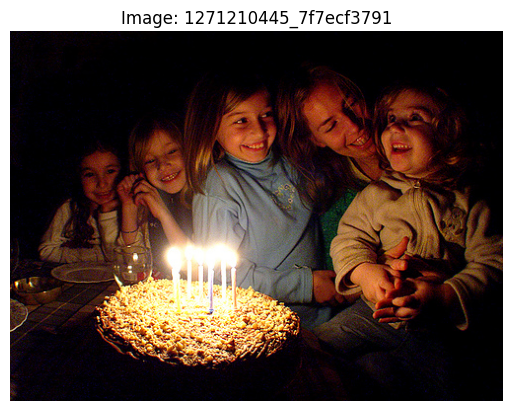

Image ID: 1473250020_dc829a090f
Prediction: a shirtless man is rock climbing startseq a rope startseq him startseq him startseq him startseq him startseq him startseq him startseq him startseq him startseq him startseq him startseq him startseq him startseq him startseq him startseq him
References:
    startseq a boy stands on a rock in a creek holding a stick endseq
    startseq a man is standing by rocks and water and is holding a stick endseq
    startseq a man who is wearing only shorts and shoes is standing on rocks with the water below him endseq
    startseq a young man in shorts is looking into a stream next to a rock wall endseq
    startseq the man is standing by a creek in blue flannel shorts endseq


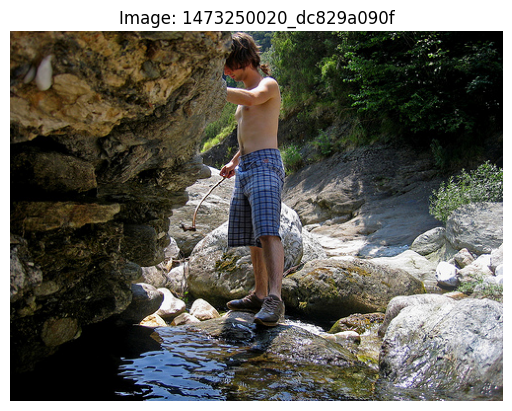

Image ID: 3349955993_a04aea97d8
Prediction: a man and woman hug at a wall startseq a clear pink cloth object startseq a building startseq a sunny day startseq a father walking startseq him startseq him startseq him startseq him startseq them startseq them startseq him
References:
    startseq a group of boys playing street soccer endseq
    startseq a group of young kids watch a group of older kids play soccer on a city street endseq
    startseq children play soccer on a narrow city street endseq
    startseq kids outside on the street playing soccer endseq
    startseq the boys are playing a game of soccer on their neighborhood street endseq


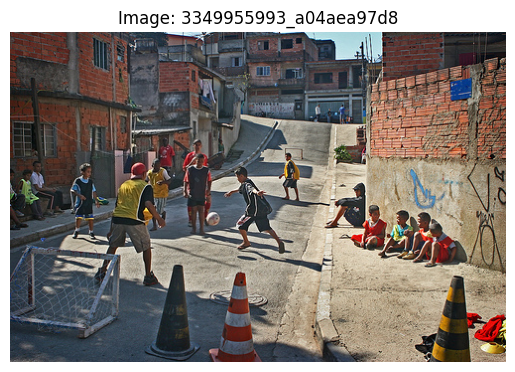

Image ID: 482907079_22085ada04
Prediction: a man is standing on a tree stump with a bird startseq him startseq startseq startseq startseq him startseq a stick startseq him startseq startseq him startseq him startseq him startseq startseq startseq startseq him startseq them startseq them
References:
    startseq a climber scales a cliff as others watch endseq
    startseq a figure is climbing up a rock while people on the grond watch endseq
    startseq a person climbs a cliff face in the woods while others watch endseq
    startseq a woman is rock climbing endseq
    startseq people are watching a man who is climbing on a rock face endseq


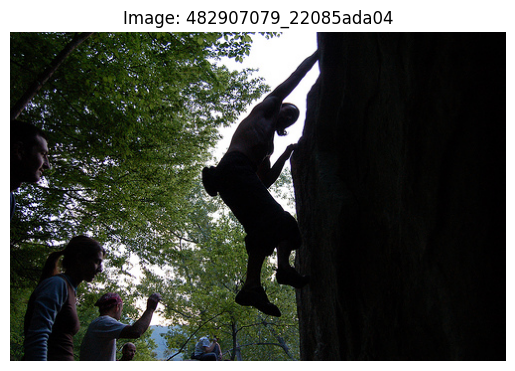

Image ID: 3632258003_6a0a69bf3a
Prediction: two boys bend over a fence startseq a boy startseq two muddy mud startseq a tennis ball startseq a boy startseq a tennis ball startseq them startseq startseq startseq startseq startseq startseq startseq startseq startseq startseq startseq startseq startseq
References:
    startseq a group of men with shovels are digging in salt endseq
    startseq four men shovel what looks like sand endseq
    startseq men shovel snow while wearing shorts endseq
    startseq men with shovels shoveling white sand endseq
    startseq these four men two shirtless are shoveling sand endseq


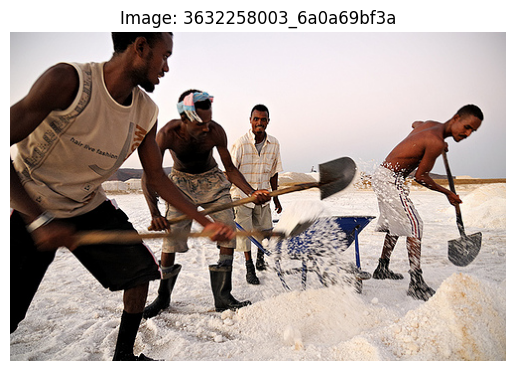

Image ID: 2909609550_070eea49b5
Prediction: a small dog is playing with a yellow ball startseq a tennis ball startseq a stick startseq a stick startseq a stick startseq his nose startseq startseq startseq startseq startseq startseq startseq startseq startseq startseq startseq startseq startseq startseq
References:
    startseq a dog staring at the end of an ice cream cone endseq
    startseq a shaggy white dog eyes the remaining part of an ice cream cone endseq
    startseq a white shaggy dog wants a bite of its owners ice cream cone endseq
    startseq dog looking at food being held by person endseq
    startseq the shaggy dog is looking at the last of an ice cream cone endseq


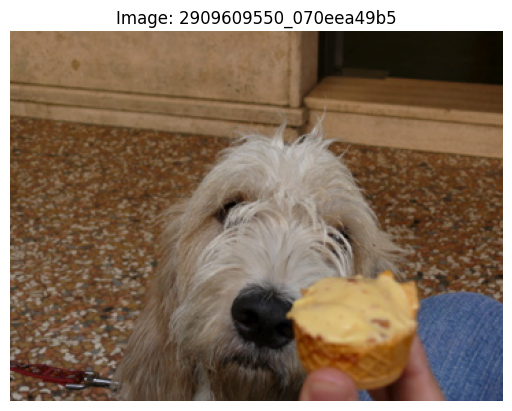

Image ID: 1625306051_7099519baa
Prediction: a man in a red shirt is jumping in the air startseq a bright orange sky startseq startseq a bright blue sky startseq startseq a bright blue sky startseq startseq a bright blue sky startseq startseq a bright blue
References:
    startseq a man in a yellow shirt and a man in an orange shirt jump in the air endseq
    startseq a man jumps off a hill endseq
    startseq two men in hiking boots strike martial arts poses endseq
    startseq two men jumping on a rock wall endseq
    startseq two men leap into the air endseq


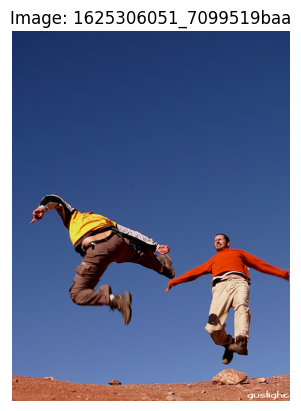

Image ID: 1174629344_a2e1a2bdbf
Prediction: a group of people walking down the street startseq a train startseq a race startseq a race startseq a race startseq a city track startseq startseq startseq startseq startseq startseq startseq startseq startseq startseq startseq startseq startseq startseq startseq
References:
    startseq a crowd of people walk down a busy sidewalk endseq
    startseq a group of different people are walking in all different directions in a city endseq
    startseq a group of people walking a city street in warm weather endseq
    startseq busy intersection in the summer time in a city endseq
    startseq people in summer clothes are walking on the sidewalk of a large city endseq


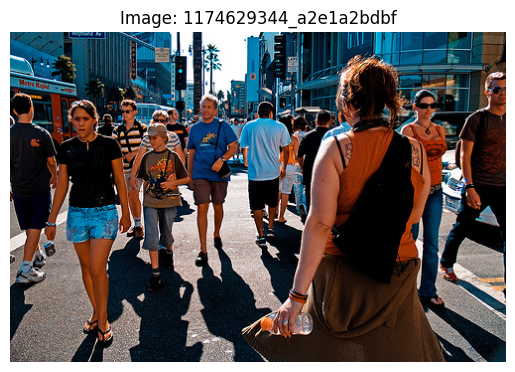

Image ID: 2916586390_664f0139ea
Prediction: a woman in a bikini top is smiling as other people are standing on a beach startseq a crowd startseq a beach startseq them startseq startseq startseq startseq startseq startseq startseq startseq startseq startseq startseq startseq startseq startseq startseq
References:
    startseq a colourfully dressed and painted woman working a hula hoop in a crowd endseq
    startseq a woman in purple pants is using a green hula hoop endseq
    startseq a woman wearing purple and green is spinning a green hula hoop around her waist endseq
    startseq a woman with jewels on her face wearing a green sports bra and purple pants is hula hooping in a crowd endseq
    startseq costumed girl playing with a hulahoop in a crowd endseq


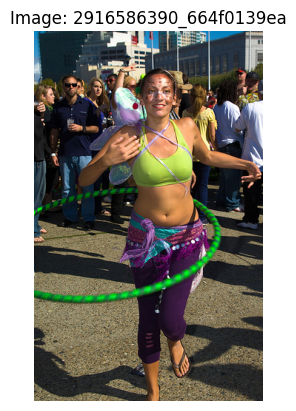

Image ID: 1771490732_0ab5f029ac
Prediction: a young boy kicking a soccer ball startseq a soccer ball startseq a soccer ball startseq a soccer ball startseq him startseq startseq startseq him startseq him startseq startseq startseq startseq startseq startseq a soccer ball startseq him startseq
References:
    startseq three boys playing soccer in a field endseq
    startseq three boys playing soccer endseq
    startseq two boys in blue and yellow uniforms play soccer with a boy in a pink printed uniform endseq
    startseq two teammates attempt to convert a soccer goal past the goalie endseq
    startseq uniformed children playing soccer endseq


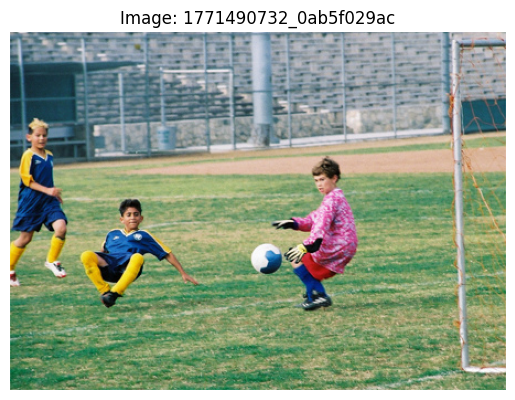

Image ID: 3241726740_6d256d61ec
Prediction: two people sit on a bench outside a building startseq a stone wall startseq startseq startseq startseq startseq startseq startseq startseq startseq startseq cold doors startseq startseq startseq startseq startseq back startseq startseq startseq back startseq far back startseq
References:
    startseq a man smoking a cigarette talking to a lady who is sitting on steps endseq
    startseq lady in black standing and smoking with another girl sitting on the steps endseq
    startseq the person in black smoked while the woman in brown sat on the steps endseq
    startseq the woman in the black coat is smoking and the woman in the gray coat sits on stone steps endseq
    startseq two women smoking on the steps of a white building endseq


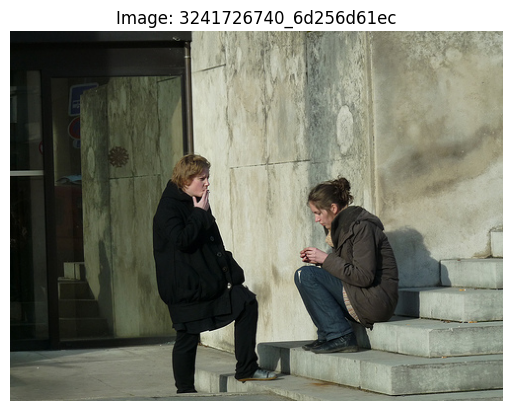

Image ID: 2831217847_555b2f95ca
Prediction: a dirty jeep is stuck in a mud puddle startseq a woods startseq a blue jeep startseq it startseq startseq startseq startseq startseq startseq startseq startseq of water startseq startseq startseq startseq startseq startseq the car startseq startseq of
References:
    startseq a blue jeep sits in the middle of a stream running through a forested area endseq
    startseq a blue land rover is driving across a river endseq
    startseq a blue suv drives in a stream surrounded by woodlands endseq
    startseq a blue suv driving over a small creek endseq
    startseq the vehicle is crossing a stream of water in a wooded area endseq


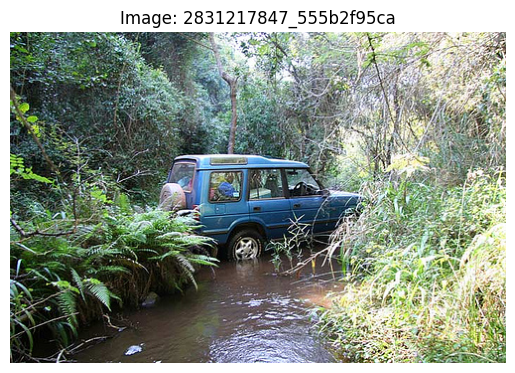

Image ID: 3138399980_d6ab8b2272
Prediction: a man in a white shirt and a girl in a red shirt and a woman in a red shirt are standing in a desert startseq a tree startseq a tree startseq a tree startseq a tree startseq a
References:
    startseq a person in an orange shirt reaching up endseq
    startseq a person wearing an orange shirt has her hand in the air as others watch endseq
    startseq a woman in a park stands with her arm up in the air endseq
    startseq a woman in orange throws her hand in the air endseq
    startseq the woman in the orange shirt has her hand raised endseq


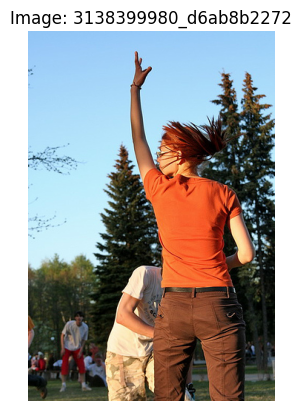

Image ID: 1245022983_fb329886dd
Prediction: a little girl in a yellow dress dancing on a yellow field startseq a yellow and yellow ball startseq a water startseq startseq startseq startseq startseq startseq startseq flip startseq startseq startseq startseq startseq startseq startseq startseq startseq startseq
References:
    startseq a child in all pink is posing nearby a stroller with buildings in the distance endseq
    startseq a little girl in pink dances with her hands on her hips endseq
    startseq a small girl wearing pink dances on the sidewalk endseq
    startseq the girl in a bright pink skirt dances near a stroller endseq
    startseq the little girl in pink has her hands on her hips endseq


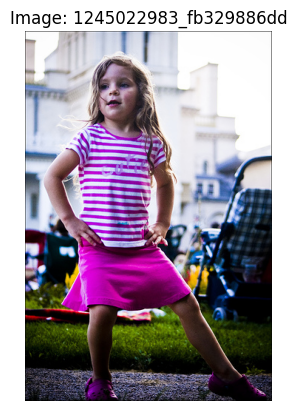

Image ID: 2887798667_ce761d45e8
Prediction: a skateboarder is jumping off a ramp startseq a stunt in the air startseq a stunt startseq his bike startseq startseq startseq startseq startseq startseq startseq startseq startseq the air startseq the window startseq a silver plaid startseq it
References:
    startseq a guy doing a wallride on his bike endseq
    startseq a person in a hooded sweatshirt is doing a bicycle trick off of a wall endseq
    startseq a person in grey is riding a bike on a brick wall endseq
    startseq a young person riding a bike on the side of a brick wall endseq
    startseq a youth on a bicycle wearing a white sweater riding along a wall endseq


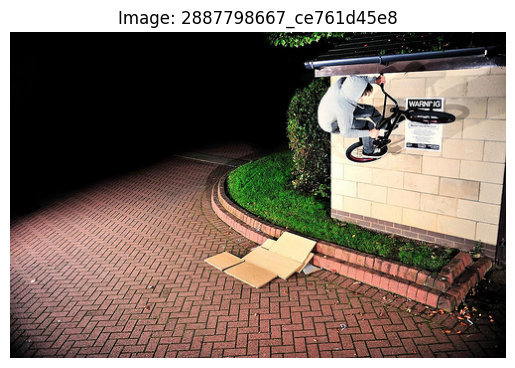

Image ID: 2473737724_355599a263
Prediction: a dog is jumping over a man in a yellow shirt startseq a flying course startseq a man startseq a chair startseq a white and blue couch startseq startseq startseq startseq startseq startseq of startseq of food competition startseq
References:
    startseq children are practicing judo on red and white mats endseq
    startseq girls do martial arts on a red mat endseq
    startseq people practicing martial arts in a training hall endseq
    startseq two children perform a karate move on a red mat endseq
    startseq two girls karate fighting endseq


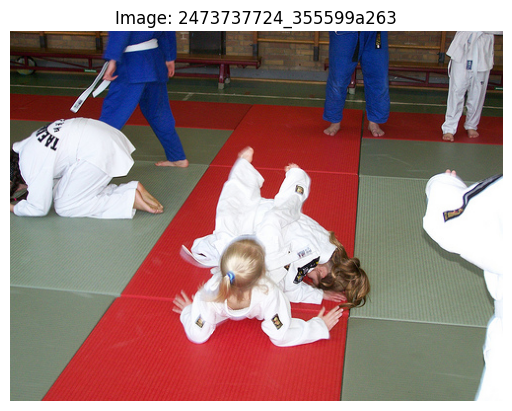

Image ID: 3091382602_60b9b53ed1
Prediction: a man and a woman looking at a book startseq a marker startseq startseq their startseq startseq startseq of startseq of startseq startseq of startseq startseq frame startseq startseq startseq frame startseq of startseq of startseq place startseq startseq
References:
    startseq a man in a white shirt and a man in a black shirt in a hallway endseq
    startseq a man in black and one in white posing indoors endseq
    startseq two guys act silly and pose for a photo endseq
    startseq two men are making hand gestures and posing for a picture endseq
    startseq two smiling young men look at the camera endseq


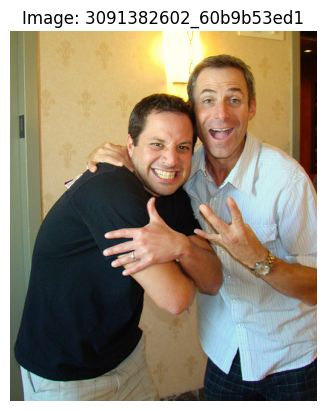

Image ID: 2417623030_afdc1024b5
Prediction: a group of people walking down a road startseq a light startseq a crowd startseq startseq startseq startseq startseq startseq startseq startseq startseq startseq startseq startseq startseq startseq startseq startseq startseq startseq startseq startseq startseq startseq back startseq startseq
References:
    startseq a group of people stand on a brick path endseq
    startseq four runners pose for a picture endseq
    startseq they are posing for a picture endseq
    startseq two couples stop to take a photo endseq
    startseq two young couples posing for a picture in exercise clothing endseq


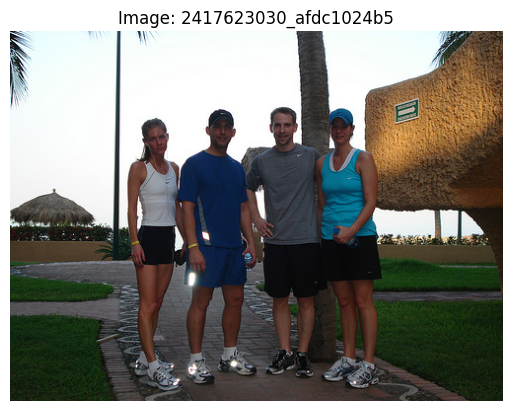

Image ID: 2195887578_3ba2f29b48
Prediction: two men in a bus startseq a bus startseq the same car startseq startseq startseq startseq startseq startseq in the back startseq startseq the bus startseq startseq startseq startseq startseq startseq startseq startseq startseq startseq distance startseq distance startseq
References:
    startseq the two men wearing ties stand in front of the sound of kildare bus endseq
    startseq two men in suits one wearing a silver medal stand in front of a blue bus endseq
    startseq two men in suits standing in front of a bus one is wearing a medal endseq
    startseq two men step off the bus together endseq
    startseq two older men in front of a bus endseq


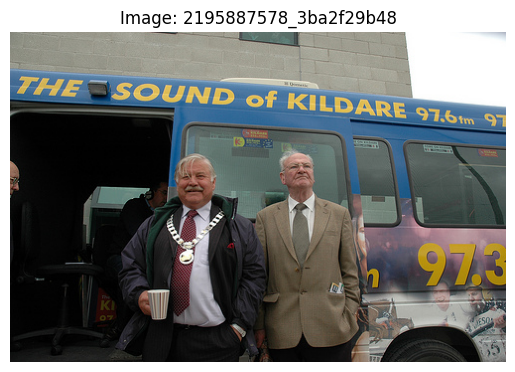

Image ID: 279901198_e7a88c855a
Prediction: a brown dog is standing in a field startseq a stick startseq a stick startseq a stick startseq a stick startseq it startseq startseq startseq of wood startseq him startseq startseq startseq startseq startseq startseq startseq startseq startseq startseq
References:
    startseq a brown dog being chased in a rural area endseq
    startseq a few brown dogs play in some dirt near woods endseq
    startseq a group of dogs running outside down a dirt trail endseq
    startseq the dogs are running outdoors near a wooded area endseq
    startseq two brown dogs run along a gravel road while another dog watches endseq


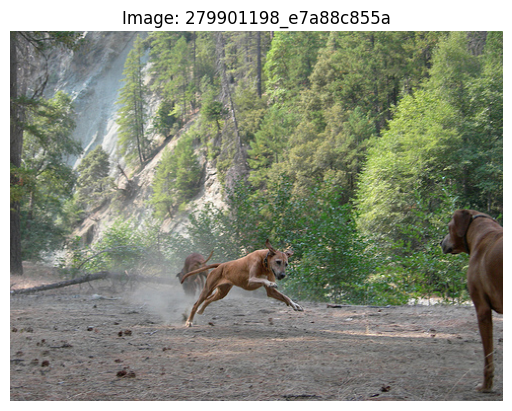

[TEST BLEU] BLEU-1: 0.2072  BLEU-2: 0.1360  BLEU-3: 0.0782  BLEU-4: 0.0434


In [37]:
import nltk
import matplotlib.pyplot as plt
from PIL import Image
import os

nltk.download('punkt', quiet=True)
from nltk.translate.bleu_score import corpus_bleu, SmoothingFunction
import json # Import json to load vocab_info

def predict_caption(photo, model, word_to_idx, idx_to_word, max_len):
    in_text = 'startseq'
    for _ in range(max_len):
        sequence = [word_to_idx.get(w, 0) for w in in_text.split() if w in word_to_idx]
        sequence = pad_sequences([sequence], maxlen=max_len, padding='post')
        ypred = model.predict([np.expand_dims(photo, axis=0), sequence], verbose=0)
        ypred_word = idx_to_word[(np.argmax(ypred))]
        in_text += ' ' + ypred_word
        if ypred_word == 'endseq':
            break
    final_caption = in_text.split()[1:-1]
    return ' '.join(final_caption)


def evaluate_model(
    encoding_data,
    descriptions,
    model,
    word_to_idx,
    idx_to_word,
    max_len,
    key_to_filepath,  # <-- dict mapping image ID to full image file path!
):
    from nltk.translate.bleu_score import corpus_bleu, SmoothingFunction
    smooth = SmoothingFunction().method1
    actual, predicted = [], []
    print_limit = 20  # Only print for the first 20
    printed = 0
    for key in descriptions.keys():
        if key not in encoding_data:
            continue
        photo = encoding_data[key]
        if photo.ndim == 2 and photo.shape[0] == 1:
            photo = photo[0]
        refs = [cap.split() for cap in descriptions[key]]
        yhat = predict_caption(photo, model, word_to_idx, idx_to_word, max_len)
        predicted.append(yhat.split())
        actual.append(refs)

        # Print and plot image for first N samples
        if printed < print_limit:
            print("="*60)
            print(f"Image ID: {key}")
            print(f"Prediction: {yhat}")
            print("References:")
            for ref in descriptions[key]:
                print(f"    {ref}")

            # --- Display image ---
            if key in key_to_filepath:
                img_path = key_to_filepath[key]
                image = Image.open(img_path)
                plt.imshow(image)
                plt.axis('off')
                plt.title(f"Image: {key}")
                plt.show()
            else:
                print("[WARN] No image file found for key:", key)

            print("="*60)
            printed += 1

    bleu1 = corpus_bleu(actual, predicted, weights=(1, 0, 0, 0), smoothing_function=smooth)
    bleu2 = corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0), smoothing_function=smooth)
    bleu3 = corpus_bleu(actual, predicted, weights=(0.33, 0.33, 0.33, 0), smoothing_function=smooth)
    bleu4 = corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25), smoothing_function=smooth)
    return bleu1, bleu2, bleu3, bleu4


# After training, or in a separate notebook session

# Load the vocab info saved during training


with open(VOCAB_DICT_PATH, 'r') as f:
    vocab_info = json.load(f)
word_to_idx = vocab_info['word_to_idx']
idx_to_word = {int(k): v for k, v in vocab_info['idx_to_word'].items()}
#vocab_size = len(word_to_idx) + 1
vocab_size = max(word_to_idx.values()) + 1
max_len = 40 # Assuming max_len is consistent from previous steps

print(VOCAB_DICT_PATH,vocab_size)
print(WEIGHTS_PATH)

image_dir = "/content/drive/My Drive/Colab Notebooks/Flicker8k_Dataset/"
key_to_filepath = {k: os.path.join(image_dir, k if k.endswith('.jpg') else k + ".jpg") for k in test_captions.keys()}

model = build_model(vocab_size, max_len, feature_dim=2048)  # or use the feature_dim you used for training
model.load_weights(WEIGHTS_PATH)
print("[INFO] Loaded best weights for inference/evaluation.")

# Evaluate on test set (not train set)
bleu1, bleu2, bleu3, bleu4 = evaluate_model(
    test_features, test_captions, model, word_to_idx, idx_to_word, max_len, key_to_filepath
)
print(f"[TEST BLEU] BLEU-1: {bleu1:.4f}  BLEU-2: {bleu2:.4f}  BLEU-3: {bleu3:.4f}  BLEU-4: {bleu4:.4f}")

In [ ]:
## Step 12: Loss Visualization


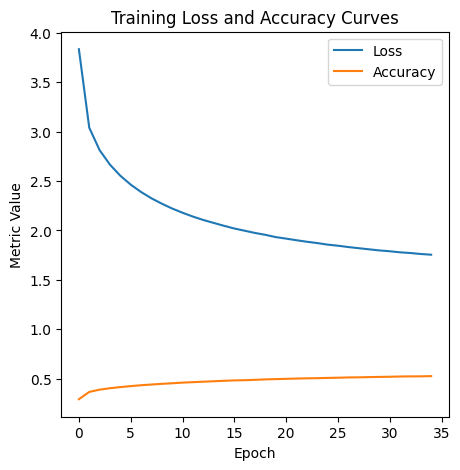

In [36]:
def plot_training_metrics(history):
    plt.figure(figsize=(5, 5))
    plt.plot(history.history['loss'], label='Loss')
    # Check for 'accuracy' or 'acc' (for older Keras)
    if 'accuracy' in history.history:
        plt.plot(history.history['accuracy'], label='Accuracy')
    elif 'acc' in history.history:
        plt.plot(history.history['acc'], label='Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Metric Value')
    plt.title('Training Loss and Accuracy Curves')
    plt.legend()
    plt.show()

plot_training_metrics(hist)